In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from PIL import Image
import cv2
import mediapipe as mp
import shutil
import sys
import time

C:\Users\dfoda\anaconda3\envs\ASLRecognition\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
SIZE = 100

In [3]:
transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor()
])

In [4]:
dataset = datasets.ImageFolder('data/processed_images_hands_init/', transform=transform)

In [5]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

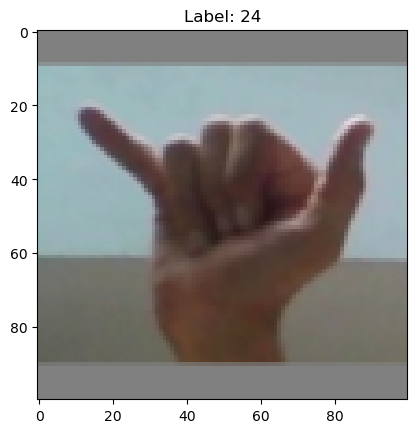

In [7]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Выбор одной картинки из batch
image = images[0]
label = labels[0]

image = image.permute(1, 2, 0).numpy()  # Перемещение размерностей из (C, H, W) в (H, W, C)
plt.imshow(image)
plt.title(f'Label: {label.item()}')
plt.show()

In [8]:
pool_size = 2
stride_size = 1
kernel_size = 3
padding = 1

In [9]:
class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=kernel_size, stride=stride_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=kernel_size, stride=stride_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.drop_out = nn.Dropout() 
        
        self.fc1 = nn.Linear(4608, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 29)

    def forward(self, x): 
         out = self.layer1(x) 
         out = self.layer2(out) 
         out = self.layer3(out)
         out = out.reshape(out.size(0), -1) 
         out = self.drop_out(out) 
         out = F.softmax(out, dim=1)
         out = self.fc1(out) 
         out = self.fc2(out) 
         out = self.fc3(out) 
         return out

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'asl_cnn_best_model.pth')
        self.val_loss_min = val_loss


In [11]:
def train_model(model, num_epochs, train_loader, val_loader, optimizer, loss_fun, accuracy, device, early_stopping=False):
    model.to(device)
    
    if early_stopping:
        early_stopping = EarlyStopping(patience=40, verbose=True)
        
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        num_batches = 0
        
        accuracy.reset()  # Reset metric at the beginning of each epoch
        
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fun(outputs, labels)
            loss.backward()
            optimizer.step()
            
            accuracy.update(outputs, labels)
            running_loss += loss.item()
            num_batches += 1
        
        average_loss = running_loss / num_batches
        epoch_accuracy = accuracy.compute()
        
        model.eval()
        val_loss = 0.0
        val_batches = 0
        val_accuracy = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", total=len(val_loader)):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fun(outputs, labels)
                val_loss += loss.item()
                val_batches += 1
                val_accuracy += torch.sum(torch.argmax(outputs, dim=1) == labels).item()
        
        average_val_loss = val_loss / val_batches
        val_accuracy = val_accuracy / len(val_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        if early_stopping:
            early_stopping(average_val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [13]:
model = SignLanguageCNN()
model.to(device)

SignLanguageCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=29, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
accuracy = torchmetrics.Accuracy(task='MULTICLASS', num_classes=29)
accuracy.to(device)

num_epochs = 40

In [39]:
train_model(model, num_epochs, train_loader, val_loader, optimizer, criterion, accuracy, device, True)

Validation Epoch 1/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:15<00:00,  2.98it/s]


Epoch [1/40], Loss: 1.9230, Accuracy: 0.4370, Val Loss: 1.4142, Val Accuracy: 0.5470
Validation loss decreased (inf --> 1.414205).  Saving model ...


Validation Epoch 2/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:08<00:00,  3.28it/s]


Epoch [2/40], Loss: 0.8842, Accuracy: 0.7337, Val Loss: 1.4281, Val Accuracy: 0.5451
EarlyStopping counter: 1 out of 40


Validation Epoch 3/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:12<00:00,  3.14it/s]


Epoch [3/40], Loss: 0.7298, Accuracy: 0.7899, Val Loss: 0.7693, Val Accuracy: 0.7440
Validation loss decreased (1.414205 --> 0.769342).  Saving model ...


Validation Epoch 4/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:21<00:00,  2.78it/s]


Epoch [4/40], Loss: 1.0593, Accuracy: 0.8028, Val Loss: 27.4002, Val Accuracy: 0.0755
EarlyStopping counter: 1 out of 40


Validation Epoch 5/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:19<00:00,  2.85it/s]


Epoch [5/40], Loss: 0.9990, Accuracy: 0.8530, Val Loss: 0.5986, Val Accuracy: 0.8063
Validation loss decreased (0.769342 --> 0.598632).  Saving model ...


Validation Epoch 6/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:15<00:00,  2.99it/s]


Epoch [6/40], Loss: 0.3362, Accuracy: 0.9034, Val Loss: 0.6166, Val Accuracy: 0.8038
EarlyStopping counter: 1 out of 40


Validation Epoch 7/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:27<00:00,  2.59it/s]


Epoch [7/40], Loss: 0.3540, Accuracy: 0.8997, Val Loss: 0.9138, Val Accuracy: 0.7067
EarlyStopping counter: 2 out of 40


Validation Epoch 8/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:25<00:00,  2.66it/s]


Epoch [8/40], Loss: 0.9331, Accuracy: 0.8458, Val Loss: 0.5799, Val Accuracy: 0.8143
Validation loss decreased (0.598632 --> 0.579902).  Saving model ...


Validation Epoch 9/40: 100%|█████████████████████████████████████████████████████████| 226/226 [01:24<00:00,  2.67it/s]


Epoch [9/40], Loss: 0.3224, Accuracy: 0.9131, Val Loss: 1.1087, Val Accuracy: 0.6426
EarlyStopping counter: 1 out of 40


Validation Epoch 10/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:21<00:00,  2.76it/s]


Epoch [10/40], Loss: 2.2490, Accuracy: 0.8559, Val Loss: 7.9167, Val Accuracy: 0.5314
EarlyStopping counter: 2 out of 40


Validation Epoch 11/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:29<00:00,  2.52it/s]


Epoch [11/40], Loss: 0.7520, Accuracy: 0.8991, Val Loss: 1.1429, Val Accuracy: 0.6807
EarlyStopping counter: 3 out of 40


Validation Epoch 12/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch [12/40], Loss: 0.3356, Accuracy: 0.9183, Val Loss: 0.6219, Val Accuracy: 0.8095
EarlyStopping counter: 4 out of 40


Validation Epoch 13/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:28<00:00,  2.57it/s]


Epoch [13/40], Loss: 0.3068, Accuracy: 0.9212, Val Loss: 1.0406, Val Accuracy: 0.6803
EarlyStopping counter: 5 out of 40


Validation Epoch 14/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:47<00:00,  2.10it/s]


Epoch [14/40], Loss: 0.3057, Accuracy: 0.9185, Val Loss: 0.9390, Val Accuracy: 0.7371
EarlyStopping counter: 6 out of 40


Validation Epoch 15/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:43<00:00,  2.18it/s]


Epoch [15/40], Loss: 1.7038, Accuracy: 0.8583, Val Loss: 0.9583, Val Accuracy: 0.8031
EarlyStopping counter: 7 out of 40


Validation Epoch 16/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:24<00:00,  2.66it/s]


Epoch [16/40], Loss: 0.3781, Accuracy: 0.9192, Val Loss: 0.4831, Val Accuracy: 0.8719
Validation loss decreased (0.579902 --> 0.483056).  Saving model ...


Validation Epoch 17/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:26<00:00,  2.63it/s]


Epoch [17/40], Loss: 0.3005, Accuracy: 0.9238, Val Loss: 0.6075, Val Accuracy: 0.8228
EarlyStopping counter: 1 out of 40


Validation Epoch 18/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:29<00:00,  2.52it/s]


Epoch [18/40], Loss: 0.3244, Accuracy: 0.9169, Val Loss: 0.5473, Val Accuracy: 0.8316
EarlyStopping counter: 2 out of 40


Validation Epoch 19/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:24<00:00,  2.69it/s]


Epoch [19/40], Loss: 2.5345, Accuracy: 0.8558, Val Loss: 1.3452, Val Accuracy: 0.7219
EarlyStopping counter: 3 out of 40


Validation Epoch 20/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:23<00:00,  2.71it/s]


Epoch [20/40], Loss: 0.4475, Accuracy: 0.9138, Val Loss: 0.4715, Val Accuracy: 0.8462
Validation loss decreased (0.483056 --> 0.471545).  Saving model ...


Validation Epoch 21/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:23<00:00,  2.71it/s]


Epoch [21/40], Loss: 0.3312, Accuracy: 0.9209, Val Loss: 0.4864, Val Accuracy: 0.8665
EarlyStopping counter: 1 out of 40


Validation Epoch 22/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:27<00:00,  2.58it/s]


Epoch [22/40], Loss: 0.3092, Accuracy: 0.9243, Val Loss: 0.6505, Val Accuracy: 0.7911
EarlyStopping counter: 2 out of 40


Validation Epoch 23/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:33<00:00,  2.42it/s]


Epoch [23/40], Loss: 0.3827, Accuracy: 0.9120, Val Loss: 1.8336, Val Accuracy: 0.6068
EarlyStopping counter: 3 out of 40


Validation Epoch 24/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:10<00:00,  3.21it/s]


Epoch [24/40], Loss: 2.1799, Accuracy: 0.8602, Val Loss: 0.3341, Val Accuracy: 0.9190
Validation loss decreased (0.471545 --> 0.334064).  Saving model ...


Validation Epoch 25/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:22<00:00,  2.74it/s]


Epoch [25/40], Loss: 0.3285, Accuracy: 0.9278, Val Loss: 0.4934, Val Accuracy: 0.8686
EarlyStopping counter: 1 out of 40


Validation Epoch 26/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:17<00:00,  2.91it/s]


Epoch [26/40], Loss: 0.3000, Accuracy: 0.9295, Val Loss: 0.7252, Val Accuracy: 0.8285
EarlyStopping counter: 2 out of 40


Validation Epoch 27/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:33<00:00,  2.42it/s]


Epoch [27/40], Loss: 0.3034, Accuracy: 0.9259, Val Loss: 0.7675, Val Accuracy: 0.7692
EarlyStopping counter: 3 out of 40


Validation Epoch 28/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:29<00:00,  2.53it/s]


Epoch [28/40], Loss: 1.7590, Accuracy: 0.8748, Val Loss: 1.2591, Val Accuracy: 0.8109
EarlyStopping counter: 4 out of 40


Validation Epoch 29/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:26<00:00,  2.62it/s]


Epoch [29/40], Loss: 0.4948, Accuracy: 0.9205, Val Loss: 0.5141, Val Accuracy: 0.8663
EarlyStopping counter: 5 out of 40


Validation Epoch 30/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:36<00:00,  2.34it/s]


Epoch [30/40], Loss: 0.3199, Accuracy: 0.9297, Val Loss: 0.7043, Val Accuracy: 0.8154
EarlyStopping counter: 6 out of 40


Validation Epoch 31/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:30<00:00,  2.50it/s]


Epoch [31/40], Loss: 0.3349, Accuracy: 0.9244, Val Loss: 16.2277, Val Accuracy: 0.0902
EarlyStopping counter: 7 out of 40


Validation Epoch 32/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:47<00:00,  2.10it/s]


Epoch [32/40], Loss: 1.7364, Accuracy: 0.8860, Val Loss: 1.1810, Val Accuracy: 0.7513
EarlyStopping counter: 8 out of 40


Validation Epoch 33/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:46<00:00,  2.12it/s]


Epoch [33/40], Loss: 0.3622, Accuracy: 0.9281, Val Loss: 0.7741, Val Accuracy: 0.7906
EarlyStopping counter: 9 out of 40


Validation Epoch 34/40: 100%|████████████████████████████████████████████████████████| 226/226 [02:00<00:00,  1.88it/s]


Epoch [34/40], Loss: 0.3111, Accuracy: 0.9300, Val Loss: 0.5922, Val Accuracy: 0.8195
EarlyStopping counter: 10 out of 40


Validation Epoch 35/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:35<00:00,  2.38it/s]


Epoch [35/40], Loss: 0.8570, Accuracy: 0.8876, Val Loss: 7.4259, Val Accuracy: 0.4984
EarlyStopping counter: 11 out of 40


Validation Epoch 36/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:22<00:00,  2.75it/s]


Epoch [36/40], Loss: 1.5307, Accuracy: 0.8982, Val Loss: 0.6636, Val Accuracy: 0.8493
EarlyStopping counter: 12 out of 40


Validation Epoch 37/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:20<00:00,  2.82it/s]


Epoch [37/40], Loss: 0.3404, Accuracy: 0.9336, Val Loss: 0.2815, Val Accuracy: 0.9249
Validation loss decreased (0.334064 --> 0.281486).  Saving model ...


Validation Epoch 38/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:20<00:00,  2.80it/s]


Epoch [38/40], Loss: 0.3335, Accuracy: 0.9295, Val Loss: 0.6013, Val Accuracy: 0.8173
EarlyStopping counter: 1 out of 40


Validation Epoch 39/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:22<00:00,  2.72it/s]


Epoch [39/40], Loss: 1.7413, Accuracy: 0.8811, Val Loss: 0.9756, Val Accuracy: 0.8649
EarlyStopping counter: 2 out of 40


Validation Epoch 40/40: 100%|████████████████████████████████████████████████████████| 226/226 [01:15<00:00,  3.00it/s]

Epoch [40/40], Loss: 0.5168, Accuracy: 0.9271, Val Loss: 0.8096, Val Accuracy: 0.7766
EarlyStopping counter: 3 out of 40


In [15]:
model.load_state_dict(torch.load('asl_cnn_best_model_valacc-92-49.pth'))

<All keys matched successfully>

In [16]:
def predict_image_class(model, image, class_names):
    model.eval()
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return class_names[predicted.item()]

In [34]:
def process_image_for_prediction(image):
    tensor_image = torch.tensor(image, dtype=torch.float32)
    tensor_image = tensor_image.permute(2, 0, 1).unsqueeze(0)
    return tensor_image


In [18]:
def detect_hand(image, hands, padding=20, target_size=(300, 300), bg_color=(128, 128, 128)):
    rgb_image = image
    rgb_image.flags.writeable = False

    results = hands.process(rgb_image)

    rgb_image.flags.writeable = True

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            h, w, _ = image.shape
            x_min, y_min = w, h
            x_max, y_max = 0, 0

            landmarks = []

            for landmark in hand_landmarks.landmark:
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)
                landmarks.append((x, y, landmark.z))

            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(w, x_max + padding)
            y_max = min(h, y_max + padding)

            hand_image = image[y_min:y_max, x_min:x_max]

            hand_h, hand_w, _ = hand_image.shape
            scale = min(target_size[0] / hand_w, target_size[1] / hand_h)
            new_w = int(hand_w * scale)
            new_h = int(hand_h * scale)
            resized_hand_image = cv2.resize(hand_image, (new_w, new_h))

            result_image = np.full((target_size[1], target_size[0], 3), bg_color, dtype=np.uint8)
            x_offset = (target_size[0] - new_w) // 2
            y_offset = (target_size[1] - new_h) // 2
            result_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_hand_image

            return result_image, results, (x_min, y_min, scale, x_offset, y_offset), landmarks
    return None, None, None, None


In [25]:
def start_camera(model, hands):
    total_images = 0
    total_time = 0
    while True:
        success, image = cap.read()
        image = cv2.flip(image, 1)
        imageRGB = image
        
        hand_pattern, results, bbox_params, original_landmarks = detect_hand(image, hands)
        if results:
            for handLms in results.multi_hand_landmarks:
                draw.draw_landmarks(image, handLms, mp.solutions.hands.HAND_CONNECTIONS)

                x = int(handLms.landmark[0].x * image.shape[1])
                y = int(handLms.landmark[0].y * image.shape[0])
        
        if hand_pattern is not None:
            imageRGB = cv2.resize(hand_pattern, (SIZE, SIZE))
        else:
            imageRGB = cv2.resize(imageRGB, (SIZE, SIZE))

        if results:
            if results.multi_hand_landmarks:
                for handLms in results.multi_hand_landmarks:
                    draw.draw_landmarks(image, handLms, mp.solutions.hands.HAND_CONNECTIONS)
                    tensor_image = process_image_for_prediction(imageRGB)
                    time_s = time.time()
                    predicted_class = predict_image_class(model, tensor_image, class_names)
                    total_time += time.time() - time_s
                    total_images += 1
                    dynamic_console_output(f"Predicted class: {predicted_class}")
                    cv2.putText(image, predicted_class, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (224, 255, 255), 2, cv2.LINE_AA)
        
        image_out = image
        if hand_pattern is not None:
            hand_cam = cv2.resize(hand_pattern, (150, 150))
        else:
            hand_cam = cv2.resize(image, (150, 150))
        height, width, _ = hand_cam.shape
        height_out, width_out, _ = image_out.shape
    
        x_offset = width_out - width
        y_offset = 0
        
        image_out[y_offset:y_offset+height, x_offset:x_offset+width] = hand_cam

        cv2.imshow('Hand', image_out)
        
        if cv2.waitKey(33) != -1:
            cv2.destroyAllWindows()
            # break
            return total_time / total_images


In [21]:
def dynamic_console_output(log):
    # Получаем текущую ширину строки терминала
    terminal_width = shutil.get_terminal_size().columns

    # Обрезаем предыдущий лог до текущей ширины строки
    log = log.ljust(terminal_width)
    
    # Выводим новый лог
    sys.stdout.write("\r\033[K" + log)
    sys.stdout.flush()

In [35]:
cap = cv2.VideoCapture(0)
hands = mp.solutions.hands.Hands(max_num_hands=2)
draw = mp.solutions.drawing_utils

class_names = dataset.classes

In [36]:
start_camera(model, hands)

C:\Users\dfoda\anaconda3\envs\ASLRecognition\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Predicted class: X                                                                                                      

0.011310779530069103

In [33]:
cap.release()

In [30]:
def predict_images_in_folder(folder_path, model):
    predictions = []
    true_labels = []
    
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    
    for subfolder in subfolders:
        class_name = os.path.basename(subfolder)
        print(f'Processing images in class: {class_name}')
     
        files = [f for f in os.listdir(subfolder) if f.endswith('.jpg') or f.endswith('.png')]
        
        for file in files:
            image_path = os.path.join(subfolder, file)
            image = cv2.imread(image_path)

            hand_pattern, results_pattern, bbox_params, original_landmarks = detect_hand(image, hands)
            if hand_pattern is not None:
                imageRGB = cv2.resize(hand_pattern, (SIZE, SIZE))
            else:
                imageRGB = cv2.resize(imageRGB, (SIZE, SIZE))
            if results_pattern:
                if results_pattern.multi_hand_landmarks:
                    tensor_image = process_image_for_prediction(imageRGB)
                    predicted_class = predict_image_class(model, tensor_image, class_names)
                else:
                    predicted_class = 'nothing'
            else:
                predicted_class = 'nothing'
            predictions.append(predicted_class)
            true_labels.append(class_name)
            
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy}')

In [32]:
from sklearn.metrics import accuracy_score
path = 'data/test_images'
predict_images_in_folder(path, model)

Processing images in class: A
Processing images in class: B
Processing images in class: C
Processing images in class: D
Processing images in class: del
Processing images in class: E
Processing images in class: F
Processing images in class: G
Processing images in class: H
Processing images in class: I
Processing images in class: J
Processing images in class: K
Processing images in class: L
Processing images in class: M
Processing images in class: N
Processing images in class: nothing
Processing images in class: O
Processing images in class: P
Processing images in class: Q
Processing images in class: R
Processing images in class: S
Processing images in class: space
Processing images in class: T
Processing images in class: U
Processing images in class: V
Processing images in class: W
Processing images in class: X
Processing images in class: Y
Processing images in class: Z
Accuracy: 0.06896551724137931
